In [111]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
from math import pi, factorial
from pprint import pprint

from numpy import absolute, vdot

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer, transpile
from qiskit.tools.visualization import circuit_drawer, plot_circuit_layout, plot_histogram
from qiskit.test.mock import FakeVigo, FakeAthens
from qiskit.quantum_info import state_fidelity, random_statevector, DensityMatrix, Statevector, Operator
from qiskit import BasicAer
from qiskit.extensions import Initialize
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.extensions import snapshot_density_matrix
from qiskit.tools.jupyter import *
from qiskit.circuit.library import Permutation
from qiskit.transpiler import PassManager, CouplingMap, Layout
from qiskit.transpiler.passes import BasicSwap, LayoutTransformation, RemoveFinalMeasurements

backend = BasicAer.get_backend('unitary_simulator')

In [112]:
fake_machine = FakeAthens()
n = 5
#print(fake_machine.properties().to_dict()['gates'])

# A coupling map of fake Athens
#coupling = [[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3]]
#coupling_map = CouplingMap(couplinglist=coupling)

In [113]:
desired_vector = np.random.rand(2**n)+1j*np.random.rand(2**n)
desired_vector = desired_vector/np.linalg.norm(desired_vector)

desired_vector = random_statevector(2**n)

print(desired_vector)
print(np.linalg.norm(desired_vector))

Statevector([-0.00730401+0.04770874j,  0.00780851-0.17556905j,
             -0.23096354-0.07327886j,  0.02487026-0.02587666j,
              0.01914795-0.13230322j, -0.04481822-0.01852086j,
             -0.03279803+0.00955413j,  0.12759939-0.04721716j,
              0.06753003-0.07460165j, -0.1261215 -0.00519734j,
              0.25654283-0.15349078j, -0.0282714 -0.03929017j,
             -0.06202274+0.12792769j,  0.15890331-0.34377762j,
              0.11726469+0.15548158j, -0.08345997+0.1652858j ,
             -0.1137663 -0.13276715j, -0.15015375-0.32593435j,
              0.15364811-0.14044378j, -0.03156389+0.11762366j,
              0.08735077-0.0331637j ,  0.12747883+0.16401937j,
              0.00399675-0.20196057j, -0.00539359-0.16555593j,
              0.20170952-0.03715522j, -0.01102056+0.14967549j,
             -0.03881988-0.11247655j, -0.08886589-0.0454633j ,
             -0.04093561-0.08730969j,  0.0707387 -0.12396413j,
              0.22684309+0.03517506j,  0.0024434 -0.067

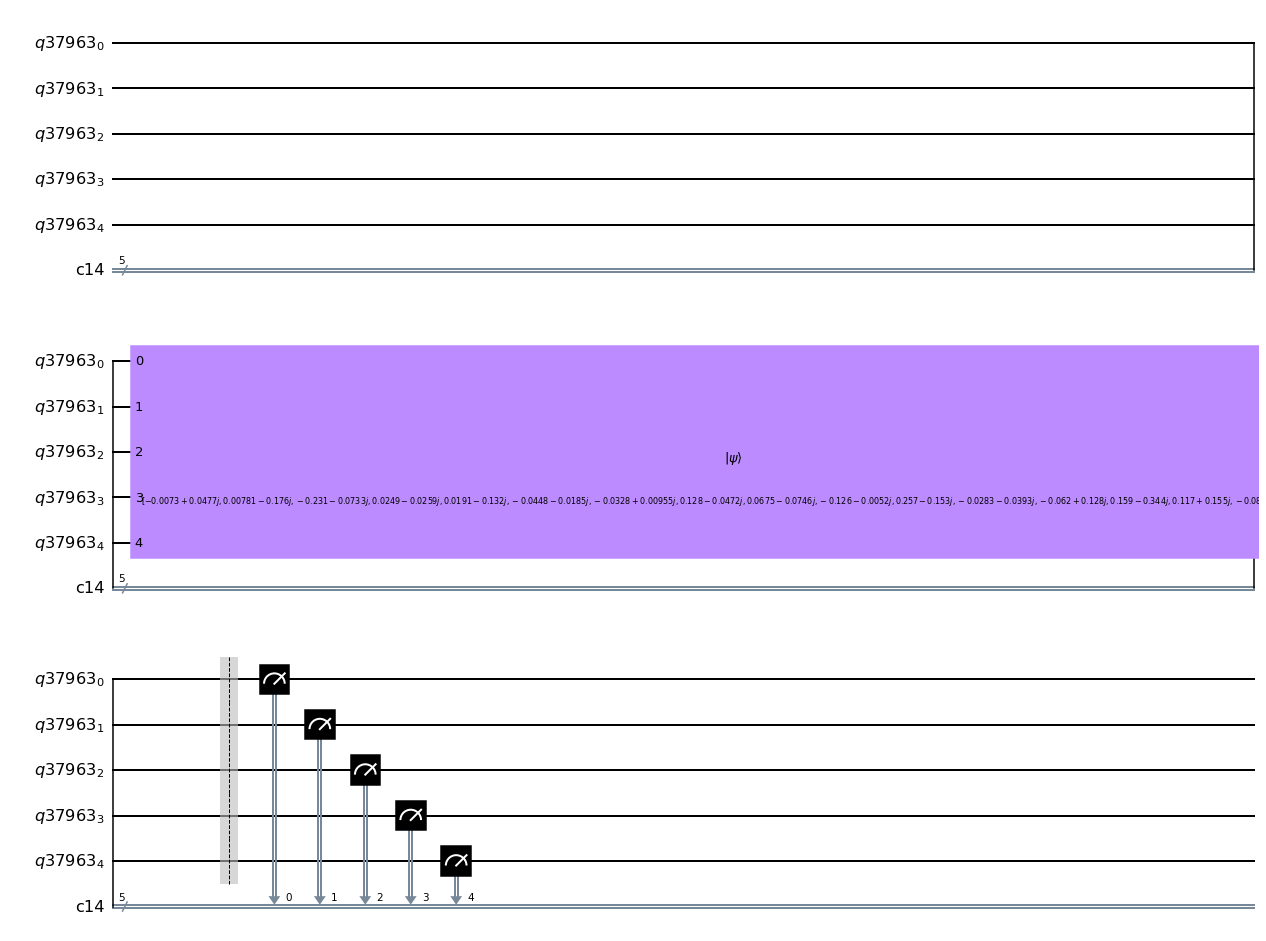

In [114]:
init = Initialize(desired_vector)
init_circ = init.gates_to_uncompute().inverse()
init_circ.draw('mpl')

qr = QuantumRegister(n)
cr = ClassicalRegister(n)
qc = QuantumCircuit(qr, cr)

qc.initialize(desired_vector, qr)
qc.barrier()
qc.measure(qr, cr)

init_circ = qc
init_circ.draw('mpl')

In [115]:
backend = BasicAer.get_backend('statevector_simulator')
job = execute(init_circ, backend)
init_state = job.result().get_statevector(init_circ)

print(state_fidelity(desired_vector,init_state))

0.017870785920722613


In [116]:
circs = []
depths = []

n_iter = 10

for _ in range(n_iter):
    new_circ = transpile(init_circ,fake_machine,optimization_level=3, approximation_degree=0.8)
    circs.append(new_circ)
    depths.append(new_circ.depth())
    
#init_circ.draw('mpl')
    
#plt.figure(figsize=(8, 6))
#plt.hist(depths, bins=list(range(min(depths),max(depths)+2)), align='left', color='#AC557C')
#plt.xlabel('Depth', fontsize=14)
#plt.ylabel('Counts', fontsize=14);

for depth in depths:
    print(depth)


235
233
233
235
257
235
255
257
255
235


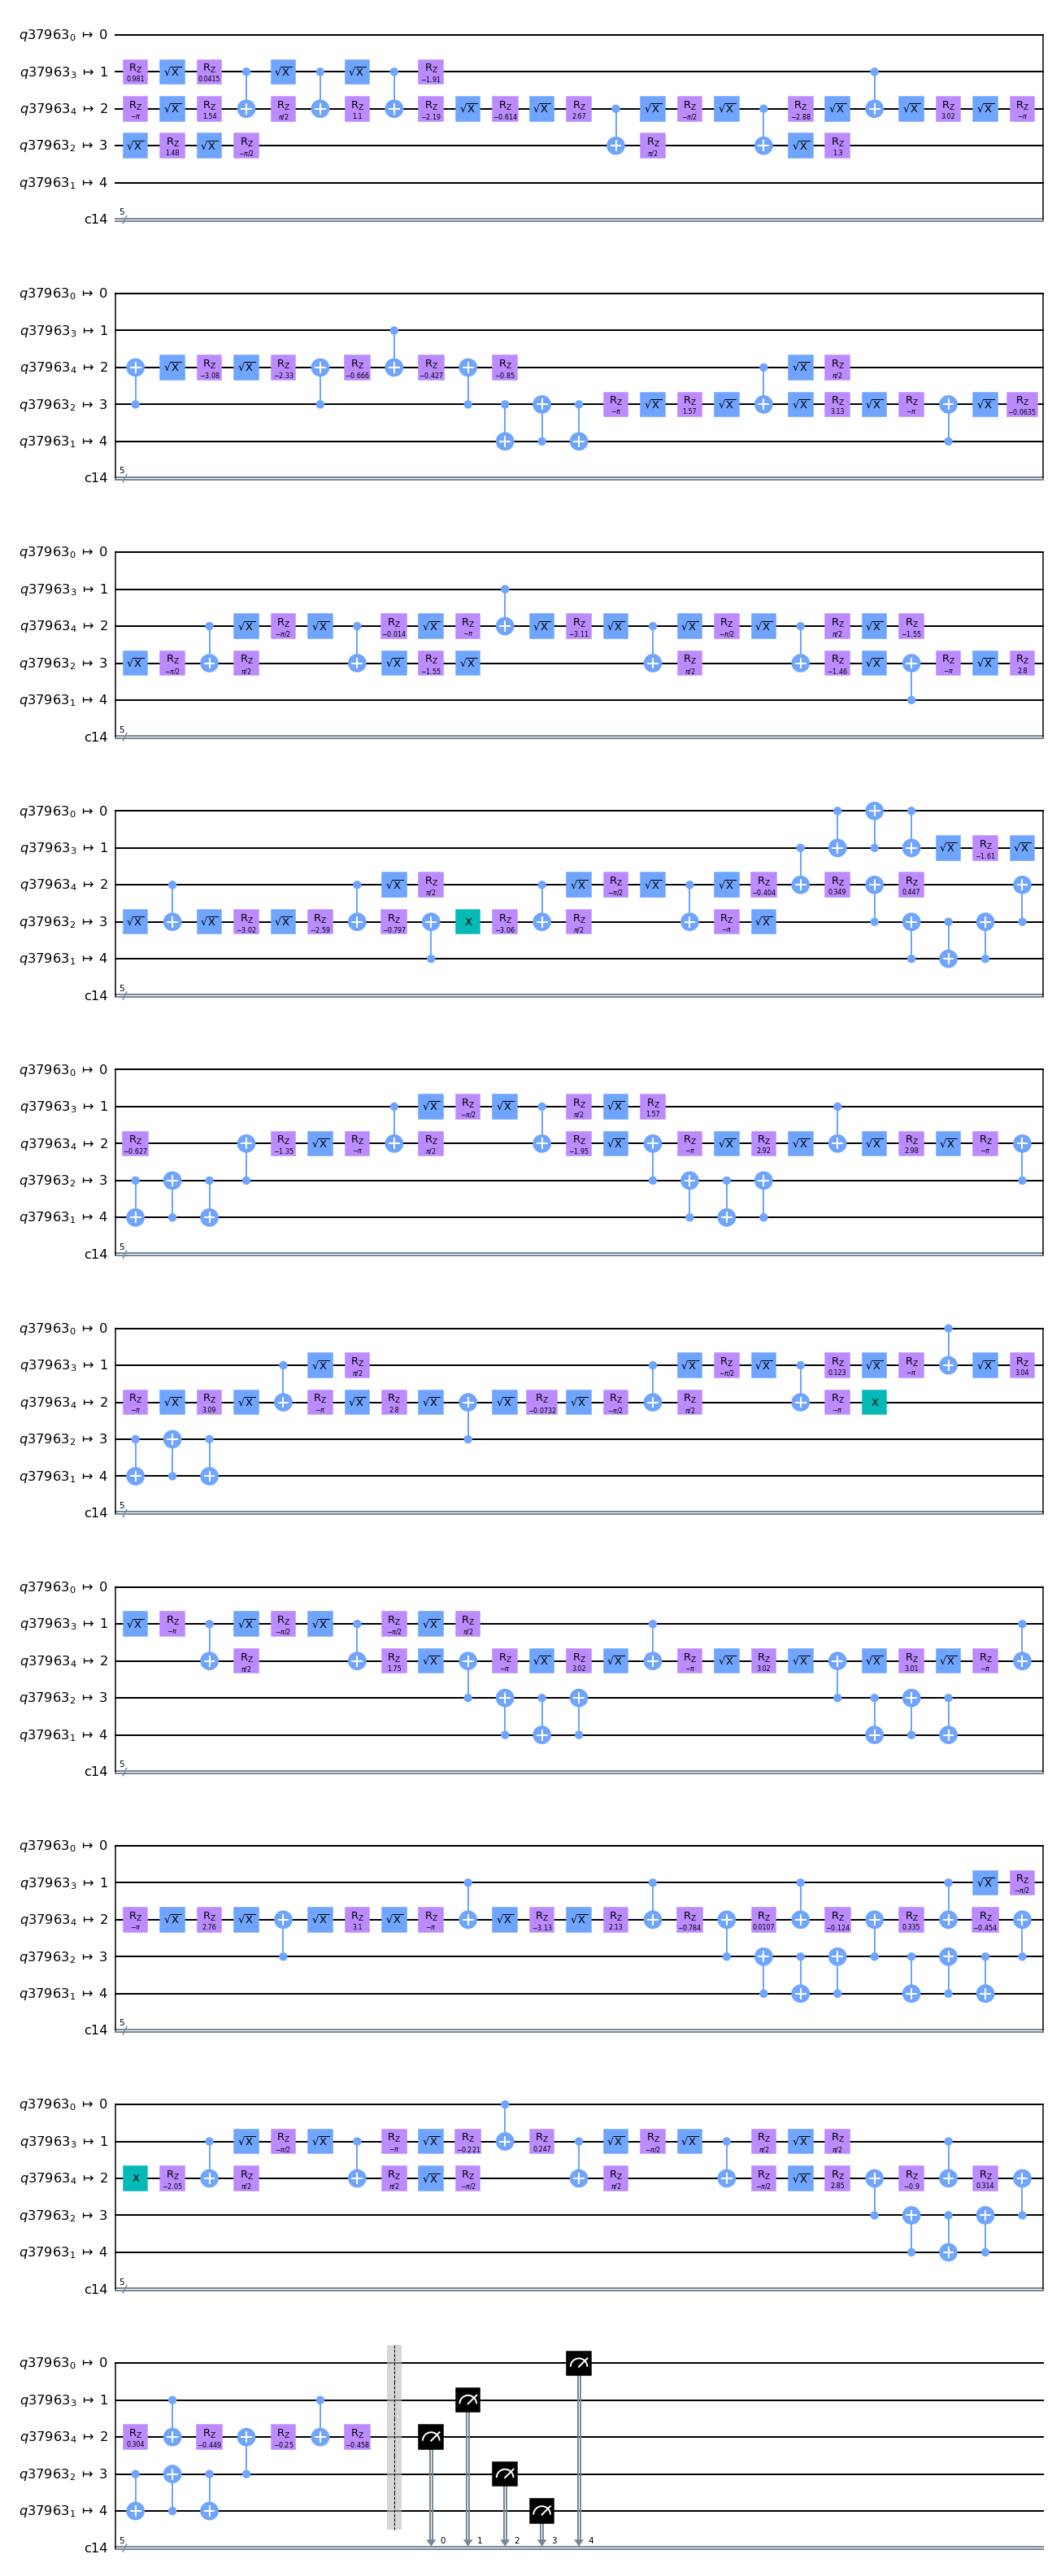

In [117]:
best_init_circ = circs[np.argmin(depths)]
best_init_circ.draw('mpl')

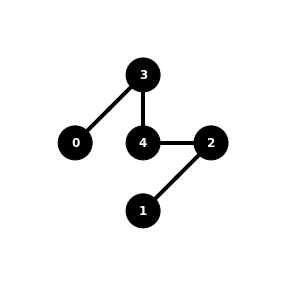

In [118]:
plot_circuit_layout(best_init_circ,fake_machine)

In [119]:
#machine_simulator = Aer.get_backend('qasm_simulator')

#best_init_circ.save_density_matrix()

#init_circ.save_density_matrix()



#for i in range(n_iter):
#    circs[i].remove_final_measurements()
#    circs[i].save_density_matrix()

C:\Users\rindelt1\AppData\Local\Temp/ipykernel_14844/3512235185.py:27: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  perm[qubits[0].index] = clbits[0].index
C:\Users\rindelt1\AppData\Local\Temp/ipykernel_14844/3512235185.py:30: DeprecationWarning: The `snapshot_density_matrix` circuit method has been deprecated as of qiskit-aer 0.9 and will be removed in a future release. It has been superseded by the `save_density_matrix` circuit method.
  circs[i].snapshot_density_matrix('final')


---
1.0000000000000038
234
---
1.0000000000000042
232
---
1.0000000000000042
232
---
1.0000000000000044
234
---
1.0000000000000053
256
---
1.0000000000000044
234
---
1.0000000000000058
254
---
1.0000000000000049
256
---
1.0000000000000056
254
---
1.0000000000000044
234
mean fidelity: 1.0000000000000047


Text(0, 0.5, 'Counts')

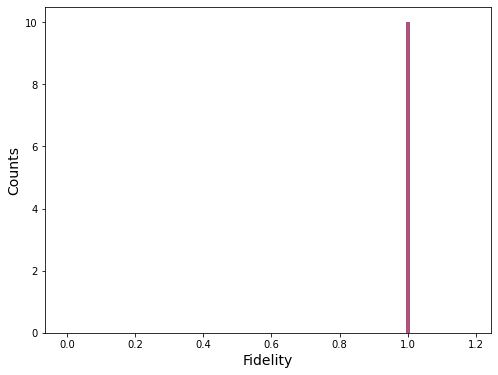

In [120]:
machine_simulator = Aer.get_backend('qasm_simulator')

#best_init_circ.snapshot_density_matrix('final')
#best_init_circ.save_density_matrix()

fidelities = []



n_shots = n_iter
pad_vectors = []

for i in range(n_iter):
    
    qubit_pattern = list(circs[i]._layout.get_virtual_bits().values()) # How virtual bits map to physical bits
    n_phys = len(qubit_pattern) # n of physical bits
    perm = [0,1,2,3,4]

    if (n < 3) :
        for j in range(n_phys):
            perm[qubit_pattern[j]] = j
    else:
        for op, qubits, clbits in circs[i].data:
            if op.name == 'measure':
                #a = perm.index(clbits[0].index)
                #b = perm[qubits[0].index]
                perm[qubits[0].index] = clbits[0].index
                #perm[a] = b
    circs[i].remove_final_measurements()
    circs[i].snapshot_density_matrix('final')
    #circs[i].save_density_matrix()
    
    qubit_pattern = perm
    aug_desired_vector = desired_vector.data

    for k in range(n_phys-n):
        aug_desired_vector = np.kron([1,0],aug_desired_vector)


    perm_circ = Permutation(n_phys, qubit_pattern) # Creating a circuit for qubit mapping
    perm_unitary = Operator(perm_circ) # Matrix for the said circuit

    perm_aug_desired_vector = perm_unitary.data @ aug_desired_vector
    pad_vectors.append(perm_aug_desired_vector)

#from itertools import permutations
#p = list(permutations(range(5), 5))
#for i in range(n_iter):
#    for j in range(factorial(5)):
#        perm_circ = Permutation(n_phys, p[j])
#        perm_unitary = Operator(perm_circ)
#        perm_aug_desired_vector = perm_unitary.data @ aug_desired_vector
#        fid = state_fidelity(perm_aug_desired_vector,execute(circs[i], machine_simulator, shots=1).result().data()['density_matrix'])
#        #fid = state_fidelity(perm_aug_desired_vector,execute(circs[i], backend).result().get_statevector(circs[i]))
#        if (1-fid < 0.01):
#            print()
#            print("circuit " + str(i))
#            print(p[j])
#            print(qubit_pattern)
#            print(fid)


from qiskit.providers.aer.noise import NoiseModel

noise_model = NoiseModel.from_backend(fake_machine)
coupling_map = fake_machine.configuration().coupling_map
basis_gates = noise_model.basis_gates

#print(perm_aug_desired_vector)

#print("RESULT")
#job = execute(best_init_circ,backend,shots=1).result()
#print(job)
for i in range(n_shots):
    result = execute(circs[i], machine_simulator,
#                     coupling_map=coupling_map,
#                     basis_gates=basis_gates,
#                     noise_model=noise_model,
                     shots=1).result()
#    job = execute(circs[i],backend)
    #print(result)
#    noisy_dens_matr = DensityMatrix(result.data()['snapshots']['density_matrix']['final'][0]['value'],n_phys*(2,))
    noisy_dens_matr = result.data()['snapshots']['density_matrix']['final'][0]['value']
#    noisy_dens_matr = DensityMatrix(result.data()['density_matrix'],n_phys*(2,))
#    noisy_dens_matr = result.data()['density_matrix']
#    noisy_dens_matr = job.result().get_statevector(circs[i])

    #print(noisy_dens_matr)
    fid = state_fidelity(pad_vectors[i],noisy_dens_matr)
    print("---")
    print(fid)
    print(circs[i].depth())
    #for _ in range(10):
    #    result = execute(circs[i], machine_simulator,
    #                  coupling_map=coupling_map,
    #                  basis_gates=basis_gates,
    #                  noise_model=noise_model,
    #                 shots=1).result()
    #    noisy_dens_matr = result.data()['snapshots']['density_matrix']['final'][0]['value']
    #    fid2 = state_fidelity(pad_vectors[i],noisy_dens_matr)
    #    print(fid2)
        
    fidelities.append(fid)
    #print(fid)
    
#print(noisy_dens_matr)
mean_fidelity = sum(fidelities)/len(fidelities)
print("mean fidelity: " + str(mean_fidelity))

plt.figure(figsize=(8, 6))
plt.hist(fidelities, bins=list(np.arange(0,1.2,0.01)), align='left', color='#AC557C')
plt.xlabel('Fidelity', fontsize=14)
plt.ylabel('Counts', fontsize=14)

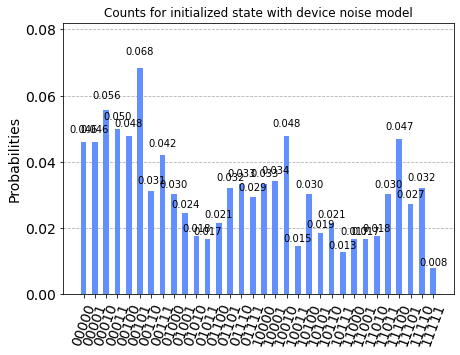

In [121]:
machine_simulator = QasmSimulator.from_backend(fake_machine)

meas = ClassicalRegister(n)

best_init_circ.add_register(meas)

best_init_circ.measure(list(range(n)), list(range(n)))

result_noise = execute(best_init_circ, machine_simulator).result()
counts_noise = result_noise.get_counts(best_init_circ)
plot_histogram(counts_noise, title="Counts for initialized state with device noise model")

dict_values([0, 4, 3, 1, 2])


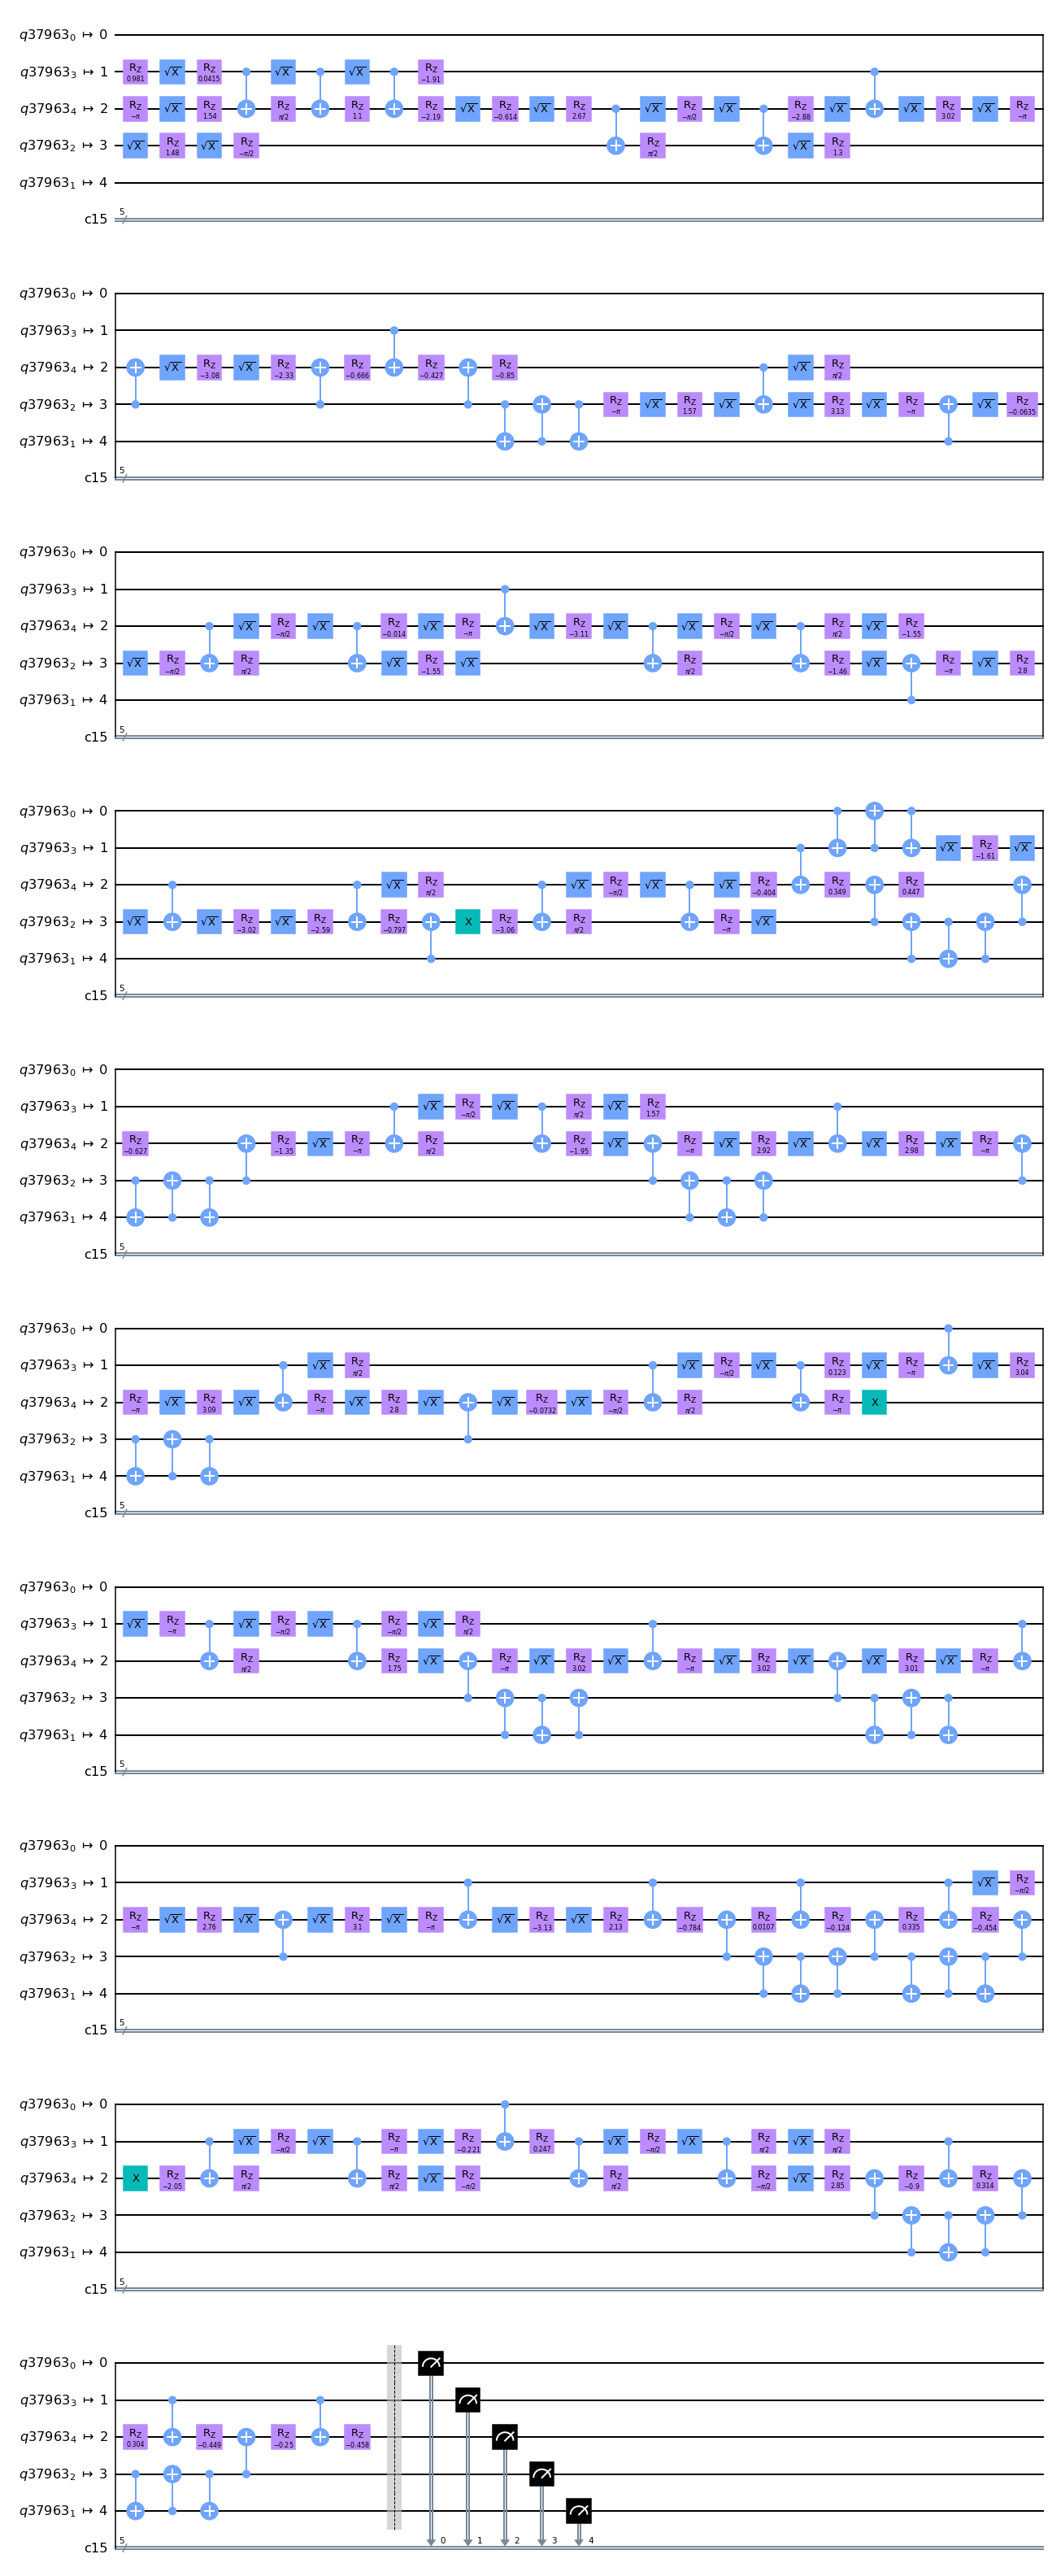

In [122]:
print(best_init_circ._layout.get_virtual_bits().values())
best_init_circ.draw('mpl')

In [123]:
fake_machine

<FakeAthens('fake_athens')>

In [124]:
pattern = list(best_init_circ._layout.get_virtual_bits().values())
print(pattern)

[0, 4, 3, 1, 2]


In [125]:
augmented_desired_vector = desired_vector

for k in range(2):
    augmented_desired_vector = np.kron(augmented_desired_vector,[1,0])

permutation_circ = Permutation(5,[2,1,0,3,4])
permutation_unitary = Operator(permutation_circ)

perm_vector = permutation_unitary.data @ augmented_desired_vector

print(perm_vector)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 128 is different from 32)

In [ ]:
permutation_unitary.data

In [ ]:
augmented_desired_vector

In [ ]:
print(augmented_desired_vector)
print(permutation_unitary.data @ augmented_desired_vector)

In [ ]:
backend = BasicAer.get_backend('statevector_simulator')
for circ in circs:

    job = execute(circ, backend)
    init_state = job.result().get_statevector(circ)
    
    print(absolute(vdot(desired_vector, init_state))**2)
    print(state_fidelity(desired_vector,init_state))
    print(list(circ._layout.get_virtual_bits().values()))

# 